In [1]:
import matplotlib.pylab as plt
import pandas as pd
from sklearn.linear_model import BayesianRidge, Lasso, LassoCV, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from pandas_util import normalize_columns

In [2]:
car_df = pd.read_csv("./datasets/dmba/ToyotaCorolla.csv")
car_df = car_df.iloc[:1000]
normalize_columns(car_df)
car_df.head(3)

,id,model,price,age_08_04,mfg_month,mfg_year,km,fuel_type,hp,met_color,...,powered_windows,power_steering,radio,mistlamps,sport_model,backseat_divider,metallic_rim,radio_cassette,parking_assistant,tow_bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0


In [3]:
predictors = [
    "age_08_04",
    "km",
    "fuel_type",
    "hp",
    "met_color",
    "automatic",
    "cc",
    "doors",
    "quarterly_tax",
    "weight",
]
outcome = "price"

In [4]:
# Partition data.
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.4, random_state=1
)

In [5]:
car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

LinearRegression()

In [6]:
# Print coefficients
print(pd.DataFrame({"Predictor": X.columns, "coefficient": car_lm.coef_}))

           Predictor  coefficient
0          age_08_04  -140.748761
1                 km    -0.017840
2                 hp    36.103419
3          met_color    84.281830
4          automatic   416.781954
5                 cc     0.017737
6              doors   -50.657863
7      quarterly_tax    13.625325
8             weight    13.038711
9   fuel_type_Diesel  1066.464681
10  fuel_type_Petrol  2310.249543


In [7]:
# Print performance measures (training data)
mean_absolute_error(train_y, car_lm.predict(train_X))

1046.9071608220581

In [8]:
mean_absolute_error(valid_y, car_lm.predict(valid_X))

1017.5971544783305

<AxesSubplot:>

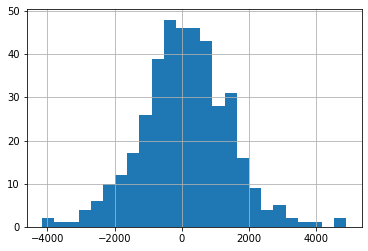

In [9]:
car_lm_pred = car_lm.predict(valid_X)
result = pd.DataFrame(
    {"Predicted": car_lm_pred, "Actual": valid_y, "Residual": valid_y - car_lm_pred}
)
result.Residual.hist(bins=25)

## Variable selection in Linear Regression

Goal is to reduce the number of predictors. This can be done by:

1) exhaustive search
2) popular subset selection algorithms, e.g. forward selection or backward elimination
3) regularization (shrinkage models)

In [18]:
from feature_selection import backward_elimination, exhaustive_search, forward_selection
from metrics import AIC_score, adjusted_r2_score

In [11]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model


def score_model(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    # We negate as score is optimized to be as low as possible.
    return -adjusted_r2_score(train_y, pred_y, model)

In [19]:
all_variables = train_X.columns
results = exhaustive_search(all_variables, train_model, score_model)

data = []
for result in results:
    model = result["model"]
    variables = list(result["variables"])
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)

    d = {"n": result["n"], "r2adj": -result["score"], "AIC": AIC}
    d.update({var: var in result["variables"] for var in all_variables})
    data.append(d)
pd.DataFrame(data, columns=("n", "r2adj", "AIC") + tuple(sorted(all_variables)))

,n,r2adj,AIC,age_08_04,automatic,cc,doors,fuel_type_Diesel,fuel_type_Petrol,hp,km,met_color,quarterly_tax,weight
0,1,-10689.712094,10689.712094,True,False,False,False,False,False,False,False,False,False,False
1,2,-10597.910645,10597.910645,True,False,False,False,False,False,True,False,False,False,False
2,3,-10506.084235,10506.084235,True,False,False,False,False,False,True,False,False,False,True
3,4,-10445.174820,10445.174820,True,False,False,False,False,False,True,True,False,False,True
4,5,-10435.578836,10435.578836,True,False,False,False,False,False,True,True,False,True,True
5,6,-10419.932278,10419.932278,True,False,False,False,False,True,True,True,False,True,True
6,7,-10418.104025,10418.104025,True,False,False,False,True,True,True,True,False,True,True
7,8,-10417.290103,10417.290103,True,True,False,False,True,True,True,True,False,True,True
8,9,-10418.789079,10418.789079,True,True,False,True,True,True,True,True,False,True,True
9,10,-10420.330800,10420.330800,True,True,False,True,True,True,True,True,True,True,True


## Backward elimination for reducint predictors in Toyota Corolla example.

In [20]:
def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)


all_variables = train_X.columns
best_model, best_variables = backward_elimination(
    all_variables, train_model, score_model, verbose=True
)
best_variables

Variables: age_08_04, km, hp, met_color, automatic, cc, doors, quarterly_tax, weight, fuel_type_Diesel, fuel_type_Petrol
Start: score=10422.30
Step: score=10420.33, remove cc
Step: score=10418.79, remove met_color
Step: score=10417.29, remove doors
Step: score=10417.29, remove None


['age_08_04',
 'km',
 'hp',
 'automatic',
 'quarterly_tax',
 'weight',
 'fuel_type_Diesel',
 'fuel_type_Petrol']

## Forward selection for reducing predictors in Toyota Corolla example

In [21]:
# The initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model


def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)

    return AIC_score(train_y, model.predict(train_X[variables]), model)

In [22]:
best_model, best_variables = forward_selection(
    train_X.columns, train_model, score_model, verbose=True
)
best_variables

Variables: age_08_04, km, hp, met_color, automatic, cc, doors, quarterly_tax, weight, fuel_type_Diesel, fuel_type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add age_08_04
Step: score=10597.91, add hp
Step: score=10506.08, add weight
Step: score=10445.17, add km
Step: score=10435.58, add quarterly_tax
Step: score=10419.93, add fuel_type_Petrol
Step: score=10418.10, add fuel_type_Diesel
Step: score=10417.29, add automatic
Step: score=10417.29, add None


['age_08_04',
 'hp',
 'weight',
 'km',
 'quarterly_tax',
 'fuel_type_Petrol',
 'fuel_type_Diesel',
 'automatic']

## Lasso and ridge regression applied to the Toyota Corolla data


In [25]:
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)
mean_absolute_error(valid_y, lasso.predict(valid_X))

1021.5286401139142

In [26]:
lasso_cv = LassoCV(normalize=True, cv=5)
lasso_cv.fit(train_X, train_y)
mean_absolute_error(valid_y, lasso_cv.predict(valid_X))

1052.464948006995

In [27]:
print("Lasso-CV chosen regularization:", lasso_cv.alpha_)
print(lasso_cv.coef_)

Lasso-CV chosen regularization: 3.5138446691310588
[-1.40370575e+02 -1.76669006e-02  3.38674037e+01  0.00000000e+00
  6.94393427e+01  0.00000000e+00  0.00000000e+00  2.70913468e+00
  1.24342596e+01 -0.00000000e+00  0.00000000e+00]


In [28]:
ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)
mean_absolute_error(valid_y, ridge.predict(valid_X))

1353.2735295225127

In [29]:
bayesian_ridge = BayesianRidge(normalize=True)
bayesian_ridge.fit(train_X, train_y)
mean_absolute_error(valid_y, bayesian_ridge.predict(valid_X))

1017.2355887928646

In [30]:
alpha = bayesian_ridge.lambda_ / bayesian_ridge.alpha_
print("Bayesian ridge chosen regularization", alpha)

Bayesian ridge chosen regularization 0.00462283343996883
